# The ~~Better~~ Bond Trading™ (BBT) Return Stream
### by Jeremy Barenholtz

## The Plan

- **Three Indicators**
    - Bond Premium and Curve Height
    - Relative Stock/Bond Performance
    - FX Appreciation<br><br>
- **Converting to a Trading Signal**
    - Going from Indicator to Signal
    - Weighting Indicators<br><br>
- **Evaluating the Return Stream**<br><br>
- **Comparing to Other Portfolios and Overlaying**
    - Portfolio A: Global Bonds
    - Portfolio C: 60/40 Global Equities and Bonds
    - Volatility-Adjusted Returns
    - Return-Adjusted Volatilities

In [12]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data import COUNTRIES, get_all_data_and_labels
from indicators import *
from signal_math import *
from stats import *
from utils import *

plt.rcParams["figure.figsize"] = (14, 4)

# Initialize the data
all_data, all_labels = get_all_data_and_labels()
all_data_clean, all_labels_clean = get_all_data_and_labels(cleaned=True)

for i, label in enumerate(all_labels):
    vars()[label] = all_data[i]
    
for i, label in enumerate(all_labels_clean):
    vars()[label] = all_data_clean[i]
    
print(*all_labels, sep='\n')

# Create modified M2 data for Australia
m2_modified = m2_usd.copy()
m2_modified['AUS'] = (m1_usd['AUS'] + m3_usd['AUS']) / 2

m2_modified_clean = m2_usd_clean.copy()
m2_modified_clean['AUS'] = (m1_usd_clean['AUS'] + m3_usd_clean['AUS']) / 2

# Get daily returns benchmark
bond_rets_daily = bond_rets_local_fx.pct_change()
equity_rets_daily = equity_prices.pct_change()

time_period = slice('1991-04-01', '2020-07-30')

bond_rets_local_fx
equity_prices
curr_acct_nom_usd
curr_acct_pct_gdp
fx_trd_wts_nom
fx_trd_wts_real
fx_vs_usd
fx_to_usd
gdp_nom
gdp_real
short_rates
long_rates
core_cpi_sa
m1_usd
m2_usd
m3_usd
inflation_rate_annual
bond_premium
curve_height
risk_free_rate


## Indicators

The three indicators I chose were 

1. Bond premium and curve height,
2. Relative stock and bond perfomance, and
3. FX appreciation.

The main reasoning for choosing these three:

- Since interest rates are the primary drivers of bond returns, I wanted an indicator that had a direct relationship with the interest rate data: bond premium and curve height.

- I wanted some metric of investor sentiment and opportunity cost, and so chose relative stock and bond performance. However, I ended up using it in an unexpected way, as a measure of relative stock/bond overvaluation.

- I wanted some metric of inflation, another driving force both for bond prices directly but more so through federal policy and interest rates. The prospectus suggested that growth in the monetary base may not be the strongest indicator, so I went with FX appreciation for its contribution to inflation.

For each indicator, I start by faithfully implementing the bond prospectus' outline:

- I compute the desired data values (e.g., bond premium or 1-year stock bond spread). Let's call that vector of values, one for each country, $\mathbf{x}$.<br><br>

- I relativize those values by subtracting the global average, $\mathbf{x}_{\text{rel}} = \mathbf{x} - \bar{x}$.<br><br>

- I standardize those relative values to the history of the indicator for each country, i.e., *how abnormal is that relative value for this country?* For example, if Japan's growth is always below the global average, this step will make sure that if we see similarly below average growth, we don't think anything special of it.<br> In proper notation, the indicator is $$I = \frac{\mathbf{x}_{\text{rel}} - \mu_{x_{rel}}}{\sigma_{x_{rel}}},$$ where $\mu_{x_{rel}}$ and $\sigma_{x_{rel}}$ are the mean and standard deviation of $x_{rel}$ through each country's history. In practice, I use windows of the history rather than all of it.<br>

Because of the limitations of time, we won't be going through much of the code, but I would look at `indicators.py` and `stats.py` within the repository, for starters, if you want to see more.

For the sake of time, we'll walk through one implementation example, for FX appreciation, and but I'll speak at a high level about the choices made for each.

```python
def fx_appreciation_indicator(
    fx_to_usd: pd.DataFrame,
    window: int = 6,
    std_window: Optional[int] = None
) -> pd.Series:
    """
    Computes the FX appreciation indicator, a percent change in each country's
    currency vs. the USD over the specified window in months.

    Args:
        fx_to_usd: A DataFrame containing each country's currency to USD 
            exchange rate (only changes need to matter).
        window: The number of months over which to take the change.
        std_window: The window over which to standardize the indicator. If None,
            uses all historical data available at the time.

    Returns:
        Today's indicator values.

    """
    
    fx_apprec_win = fx_to_usd.pct_change(window)
    fx_apprec_win_relative = relativize_to_avg(fx_apprec_win)
    fx_apprec_win_z = standardize(fx_apprec_win_relative,
                                  window=std_window)

    indicator = fx_apprec_win_z.iloc[-1].fillna(0)
    return indicator
```

And how I generate the historical indicator values for each:

```python
def test_indicator(
    indicator_fn: Callable[..., pd.Series],
    index: pd.Index,
    data: Tuple[pd.DataFrame, ...],
    args: Tuple[Any, ...] = None,
    kwargs: Dict[str, Any] = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # [Docstring and some setup code ommitted for brevity]

    for i, period in enumerate(index):
        indicator = indicator_fn(*(d[:period] for d in data), *args, **kwargs)
        indicators.append(indicator)

        trading_signal = indicators_to_trading_signal([indicator])
        assert (trading_signal <= 1).all() and (trading_signal >= -1).all()

        signals.append(trading_signal)

    indicators = pd.concat(indicators, axis=1).T
    signals = pd.concat(signals, axis=1).T

    # Convert to daily signal if the data is not daily
    if signals.index.freq in ['M', 'Q-DEC']:
        
        # Since 'M' and 'Q-DEC' are at the period's *end*, we don't have access
        # to a month's data until the following month. Thus, we shift down by 1 
        # and forward fill, so each day of this period has last period's values.
        signals = signals.shift(1).resample('B').ffill()

    if indicators.index.freq in ['M', 'Q-DEC']:
        indicators = indicators.shift(1).resample('B').ffill()

    return indicators, signals
```

### Bond Premium and Curve Height

- $\text{Bond Premium} = \text{Long Rates} - \text{Short Rates}$
    - We believe that a relatively high bond premium has a positive relationship with bond returns, as the long positions will be relatively more attractive to investors, and the long end will "revert to normal".<br><br>

- $\text{Curve Height} = \frac{\text{Long Rates} + \text{Short Rates}}{2}$<br><br>
  
- The prospectus hypothesizes that we can use Curve Height to augment the Bond Premium indicator. When both Bond Premium and Curve Height are high, we think bonds returns will increase, so I combine the two indicators additively. It states that if Bond Premium is high but curve height is low, then short rates will rise, but I found this not to be the case in practice, since countries with relatively low curve heights like the U.S. still remain attractive to investors on the basis of other factors like perceived risk, which are distributed unequally.

### Relative Stock and Bond Performance

- The indicator looks at 1-year stock returns minus 1-year bond returns within a country.<br><br>

- The prospectus hypothesizes that a large spread will lead to investors projecting those returns forward and continuing to seek higher returns in stocks. I wanted to test out a different hypothesis for this one, that the investors projecting past performance forward and shifting towards stocks is likely already priced in at the time of analysis, and, rather, that the stock-bond spread could instead be used as a proxy for overvaluation of stocks relative to bonds, predicting a movement in the other direction as prices revert to normal. Since investors are relatively short-term thinkers, I also tried standardizing over a much shorter history, and settled on a 1-year rolling window, though this is somewhat arbitrarily chosen.<br><br>

- Importantly, when combining this indicator, I shift the indicator forward by one day. This is due to some potential problems with the daily data and the timezones of each country's data reported on a given day. I have found some evidence to suggest that within a row of daily data, some countries' data is from the future relative to others.

In [2]:
indic_premium_and_height, sigs_premium_and_height = test_indicator(
    bond_premium_and_curve_height_indicator,
    index=long_rates.index,
    data=(long_rates, short_rates),
    kwargs={'std_window_height': 4 * MONTHS_PER_YEAR}
)

In [3]:
indic_stock_bond, sigs_stock_bond = test_indicator(
    stock_bond_performance_indicator,
    index=equity_prices.index,
    data=(equity_prices, bond_rets_local_fx),
    kwargs={'std_window': 1 * WEEKDAYS_PER_YEAR}
)

In [4]:
indic_fx, sigs_fx = test_indicator(
    fx_appreciation_indicator,
    index=fx_to_usd.index,
    data=(fx_to_usd,),
    kwargs={'window': 4}
)

In [5]:
indic_monetary_base, _ = test_indicator(
    monetary_base_indicator,
    index=m2_modified.index,
    data=(m2_modified,),
    kwargs={'std_window': 5 * MONTHS_PER_YEAR}
)

# Converting to a Trading Signal

## Going from Indicator to Signal

- Since my indicators' outputs are quoted in standard deviations, I proportion them to the rarity of their occurrence in a normal distribution (and then I add back its sign). Let $z$ be the output value of an indicator for one country. This step looks like $$\operatorname{sign}(z)\cdot \big[1 - 2 \cdot \operatorname{CDF_{\text{norm}}}(-|z|)\big].$$
Think of this as a value from zero to one (or zero to negative one) of how rare this event is for the country.<br><br>

- I then multiply this number by $1.1$ and clip to between $-1$ and $1$ to obtain the final signal. Multiplying by $1.1$ pushes any value above $0.9$ or below $-0.9$ to $1$ or $-1$, which seemed sensible to strengthen the signal given how the slowly normal CDF approaches 0 at the boundary.



## Combining Indicators

- To combine indicators, I take a weighted sum of them, but since I want the indicators to work together additively, the total of these weights equal the number of indicators plus one. This means that several strong indicators in the same direction will quickly push the signal to 1 or -1, several weak indicators in the same direction have the opportunity to produce a strong signal, and conflicting indicators will combine to produce a much weaker signal.<br><br>

- To avoid overfitting to the historical data, I constrain that each indicator must appear with at least a weight of 1. The remaining weights are determined by maximizing a diversification metric, that is find the weights $w$ that maximize $$\frac{w \times \sigma}{\sqrt{w^{\textsf{T}} \cdot \Sigma \cdot w}},$$ where $\sigma$ is the standard deviations of the assets and $\Sigma$ is the covariance matrix. This optimization strategy performs best under the assumption that markets are risk efficient, and with more time I'd like to test that assumption and different strategies.


## Creating the Signal

In [6]:
# Create the return streams induced by the signal
rets_premium_and_height, _ = calculate_returns(
    *make_comparable(sigs_premium_and_height, bond_rets_daily)
)
rets_fx, _ = calculate_returns(
    *make_comparable(sigs_fx, bond_rets_daily)
)
rets_stock_bond, _ = calculate_returns(
    *make_comparable(sigs_stock_bond, bond_rets_daily)
)
rets_all = pd.concat([rets_premium_and_height, rets_fx, rets_stock_bond], axis=1)
weights, _ = maximize_diversification(rets_all)

bbt_signal = indicators_to_trading_signal(
    [indic_premium_and_height, indic_fx, indic_stock_bond], 1 + weights
)

For reference, we can see that the return streams induced by each indicator separately have nearly no correlation or very slight negative correlation with each other. (It's a bit hard to interpret the strength of the correlations given how many datapoints there are though; conventionally, they look extremely weak.)

In [7]:
rets_all.rename(columns={0: 'premium & height', 1: 'fx apprec.', 2: 'stock/bond'}).corr()

,premium & height,fx apprec.,stock/bond
premium & height,1.000000,0.009628,-0.078985
fx apprec.,0.009628,1.000000,-0.060657
stock/bond,-0.078985,-0.060657,1.000000


## BBT Return Stream

In [8]:
def display_portfolio(total_ret, annual_ret, cum_ret, sharpe, vol, title, country_cum_ret=None):
    print(f'======  {title}  ======')
    print(f'Total Return: {total_ret * 100:.2f}%')
    print(f'Annualized Return: {annual_ret * 100:.2f}%')
    print(f'Sharpe Ratio: {sharpe:.5f}')
    print(f'Volatility: {vol:.5f}')

    cum_ret.plot(
        title=f'{title} Cumulative Returns',
        ylabel='return (decimal)'
    )
    
    if country_cum_ret is not None:
        country_cum_ret.plot(
            title=f'{title} Cumulative Returns by Country',
            ylabel='return (decimal)'
        )
    
    plt.show()

======  BBT Signal  ======
Total Return: 225.37%
Annualized Return: 4.11%
Sharpe Ratio: 0.72645
Volatility: 0.02187


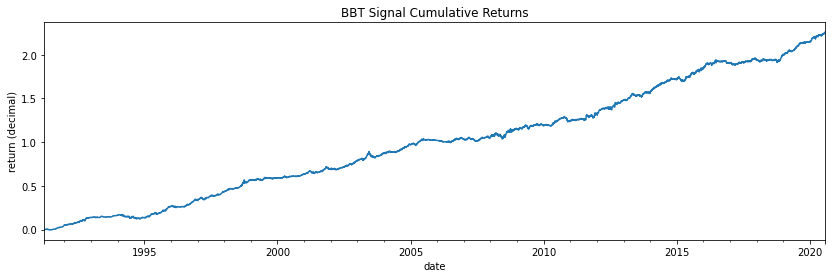

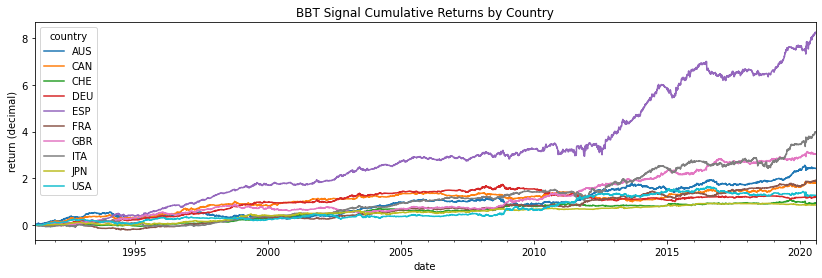

In [9]:
pf_bbt_rets, pf_bbt_country_rets = calculate_returns(*make_comparable(bbt_signal, bond_rets_daily))

pf_bbt_total_ret = compute_total_return(pf_bbt_rets)
pf_bbt_ann_ret = compute_annualized_return(pf_bbt_rets)
pf_bbt_cum_rets = compute_cumulative_return_history(pf_bbt_rets)
pf_bbt_country_cum_rets = compute_cumulative_return_history(pf_bbt_country_rets)
pf_bbt_sharpe = compute_sharpe_ratio(pf_bbt_rets, risk_free_rate)
pf_bbt_vol = compute_annualized_volatility(pf_bbt_rets)

display_portfolio(pf_bbt_total_ret, pf_bbt_ann_ret, pf_bbt_cum_rets, pf_bbt_sharpe,
                  pf_bbt_vol, 'BBT Signal', pf_bbt_country_cum_rets)

```
======  BBT Signal  ======
Total Return: 225.37%
Annualized Return: 4.11%
Sharpe Ratio: 0.72645
Volatility: 0.02187
```

![BBT Cumulative Returns](bbt_cumulative.jpg)
![BBT Cumulative Country Returns](bbt_cumulative_country.jpg)

![BBT Cumulative Country Returns](bbt_cumulative_country.jpg)

The returns look modest across the board, but I'm inclined to be skeptical about Spain. At first glance it looks as though it's simply attempting to go long on Spanish bonds.

In [13]:
cnts = (bbt_signal['ESP'][time_period] > 0).value_counts()
print(f'Percent short signals: {cnts[False] * 100 / cnts[True]:.2f}%')

Percent short signals: 29.40%


In [14]:
# After the 2013 spike
cnts = (bbt_signal['ESP']['2013':] > 0).value_counts()
print(f'Percent short signals after 2013: {cnts[False] * 100 / cnts[True]:.2f}%')

Percent short signals after 2013: 46.95%


## Comparing to Other Portfolios and Overlaying

### Portfolio A: Long Global Bonds

======  Portfolio A: Global Bonds  ======
Total Return: 658.79%
Annualized Return: 7.16%
Sharpe Ratio: 1.18066
Volatility: 0.03835


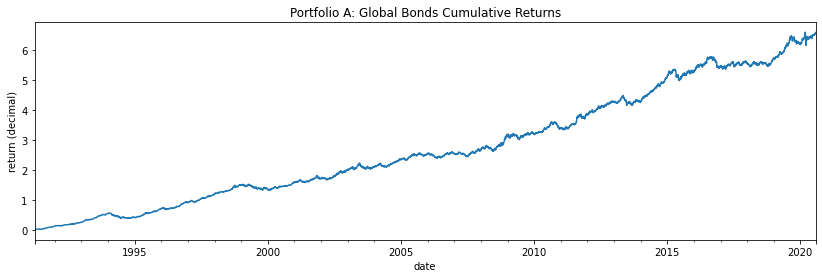

In [15]:
pf_a_rets = bond_rets_daily[time_period].mean(axis=1)
pf_a_total_ret = compute_total_return(pf_a_rets)
pf_a_ann_ret = compute_annualized_return(pf_a_rets)
pf_a_cum_rets = compute_cumulative_return_history(pf_a_rets)
pf_a_sharpe = compute_sharpe_ratio(pf_a_rets, risk_free_rate)
pf_a_vol = compute_annualized_volatility(pf_a_rets)

display_portfolio(pf_a_total_ret, pf_a_ann_ret, pf_a_cum_rets, pf_a_sharpe,
                  pf_a_vol, title='Portfolio A: Global Bonds')

```
======  Portfolio A: Global Bonds  ======
Total Return: 658.79%
Annualized Return: 7.16%
Sharpe Ratio: 1.18066
Volatility: 0.03835
```

![PF A Cumulative Returns](pf_a_cumulative.jpg)

As you can see, even on a risk-adjusted basis, the passive global bond portfolio is difficult to beat, with high excess returns per unit volatility.

However, let's see if my BBT return stream can be additive to this portfolio.

======  52/48 Portfolio A and BBT  ======
Total Return: 410.05%
Annualized Return: 5.71%
Sharpe Ratio: 1.30931
Volatility: 0.02388


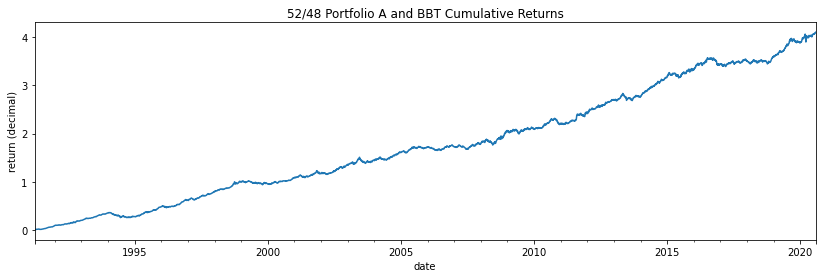

In [16]:
ws, pf_a_overlay_sharpe = maximize_sharpe_ratio([pf_a_rets, pf_bbt_rets],
                                                risk_free_rate)
pf_a_overlay_rets = ws[0] * pf_a_rets + ws[1] * pf_bbt_rets
pf_a_overlay_total_ret = compute_total_return(pf_a_overlay_rets)
pf_a_overlay_ann_ret = compute_annualized_return(pf_a_overlay_rets)
pf_a_overlay_cum_rets = compute_cumulative_return_history(pf_a_overlay_rets)
pf_a_overlay_vol = compute_annualized_volatility(pf_a_overlay_rets)

display_portfolio(pf_a_overlay_total_ret, pf_a_overlay_ann_ret,
        pf_a_overlay_cum_rets, pf_a_overlay_sharpe, pf_a_overlay_vol, 
        title=f'{round(ws[0] * 100)}/{round(ws[1] * 100)} Portfolio A and BBT')

```
======  52/48 Portfolio A and BBT  ======
Total Return: 410.05%
Annualized Return: 5.71%
Sharpe Ratio: 1.30931
Volatility: 0.02389
```

![](pf_a_overlay_cumulative.jpg)

The combined portfolio has 60% of the volatility of the global bond portfolio and a better risk-adjusted excess return shown through the slightly higher Sharpe ratio.

Let's examine the two portfolios on a volatility adjusted basis. First lets adjust the daily returns of the overlay as is to match the volatility of the Global Bond portfolio:

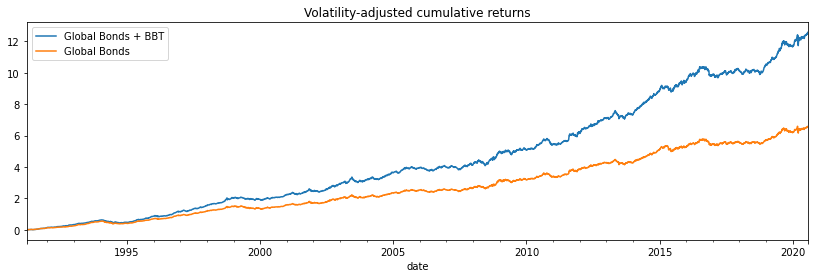

In [17]:
compute_cumulative_return_history(
    pf_a_overlay_rets * (pf_a_vol / pf_a_overlay_vol)
).plot(title='Volatility-adjusted cumulative returns', label='Global Bonds + BBT')

compute_cumulative_return_history(pf_a_rets).plot(label='Global Bonds')

plt.legend()
plt.show()

It seems like it does far better, consistently, over time on this basis. But if we look only at returns in excess of the risk free rate, we get a different picture.

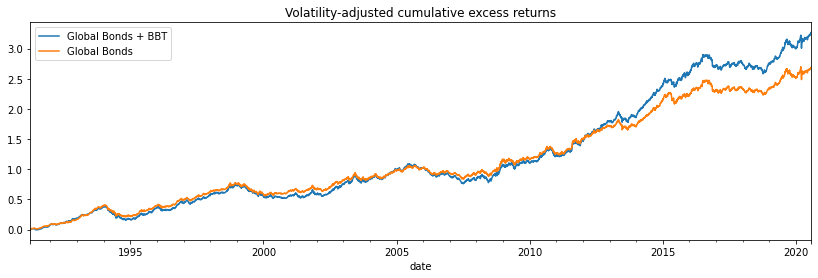

In [18]:
risk_free_rate_daily = ((1 + risk_free_rate).pow(1 / WEEKDAYS_PER_YEAR) - 1) \
                       .resample('B').ffill()[time_period]

compute_cumulative_return_history(
    (pf_a_overlay_rets - risk_free_rate_daily) * (pf_a_vol / pf_a_overlay_vol)
).plot(title='Volatility-adjusted cumulative excess returns', label='Global Bonds + BBT')

compute_cumulative_return_history(
    pf_a_rets - risk_free_rate_daily
).plot(label='Global Bonds')

plt.legend()
plt.show()

We can see that on this basis, the overlaid portfolio doesn't do better until about 2012. I want to learn more about what to take away from these metrics. It seems potentially additive, but I'm not convinced until I can shore up those questions.

## Portfolio B: Global Equities

This is mainly just to serve as a point of comparison, I don't believe anyone thinks going long on equally weighted global equities is a great idea.

======  Portfolio B: Global Equities  ======
Total Return: 323.39%
Annualized Return: 5.04%
Sharpe Ratio: 0.24018
Volatility: 0.14901


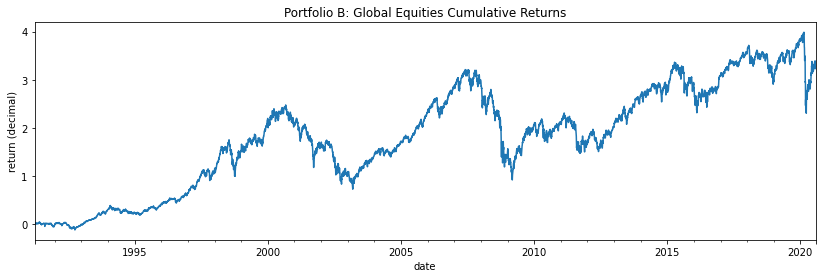

In [19]:
pf_b_rets = equity_rets_daily[time_period].mean(axis=1)
pf_b_total_ret = compute_total_return(pf_b_rets)
pf_b_ann_ret = compute_annualized_return(pf_b_rets)
pf_b_cum_rets = compute_cumulative_return_history(pf_b_rets)
pf_b_sharpe = compute_sharpe_ratio(pf_b_rets, risk_free_rate)
pf_b_vol = compute_annualized_volatility(pf_b_rets)

display_portfolio(pf_b_total_ret, pf_b_ann_ret, pf_b_cum_rets,
        pf_b_sharpe, pf_b_vol, title='Portfolio B: Global Equities')

======  4/96 Portfolio B and BBT  ======
Total Return: 233.56%
Annualized Return: 4.19%
Sharpe Ratio: 0.75885
Volatility: 0.02206


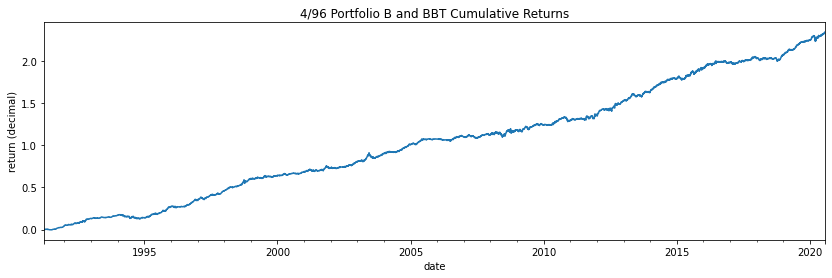

In [20]:
ws, pf_b_overlay_sharpe = maximize_sharpe_ratio([pf_b_rets, pf_bbt_rets], risk_free_rate)
pf_b_overlay_rets = ws[0] * pf_b_rets + ws[1] * pf_bbt_rets
pf_b_overlay_total_ret = compute_total_return(pf_b_overlay_rets)
pf_b_overlay_ann_ret = compute_annualized_return(pf_b_overlay_rets)
pf_b_overlay_cum_rets = compute_cumulative_return_history(pf_b_overlay_rets)
pf_b_overlay_vol = compute_annualized_volatility(pf_b_overlay_rets)

display_portfolio(pf_b_overlay_total_ret, pf_b_overlay_ann_ret, pf_b_overlay_cum_rets,
                  pf_b_overlay_sharpe, pf_b_overlay_vol,
                  title=f'{round(ws[0] * 100)}/{round(ws[1] * 100)} Portfolio B and BBT')


```
======  4/96 Portfolio and BBT  ======
Total Return: 233.56%
Annualized Return: 4.19%
Sharpe Ratio: 0.75885
Volatility: 0.02206
```

![](pf_b_overlay_cumulative.jpg)

It's interesting that on a risk-adjusted basis, the optimal portfolio would be almost entirely composed of the BBT return stream, but it makes sense given the lackluster performance and variability across global equity markets compared to bonds over the time period.

## Portfolio C: 60/40 Global Bonds and Equities


======  Portfolio C: 60/40 Global Equities and Bonds  ======
Total Return: 485.91%
Annualized Return: 6.22%
Sharpe Ratio: 0.45114
Volatility: 0.08775


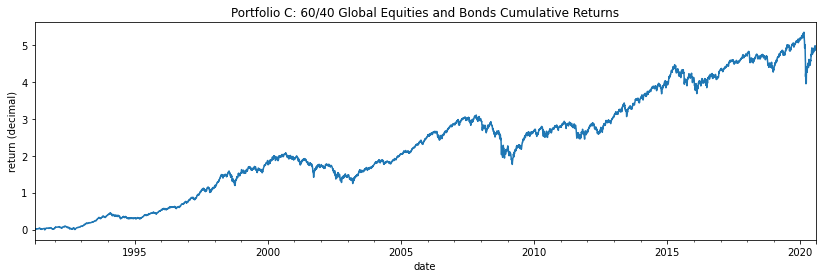

In [21]:
pf_c_rets = 0.6 * pf_b_rets + 0.4 * pf_a_rets
pf_c_total_ret = compute_total_return(pf_c_rets)
pf_c_ann_ret = compute_annualized_return(pf_c_rets)
pf_c_cum_rets = compute_cumulative_return_history(pf_c_rets)
pf_c_sharpe = compute_sharpe_ratio(pf_c_rets, risk_free_rate)
pf_c_vol = compute_annualized_volatility(pf_c_rets)

display_portfolio(pf_c_total_ret, pf_c_ann_ret, pf_c_cum_rets, pf_c_sharpe,
                  pf_c_vol, title='Portfolio C: 60/40 Global Equities and Bonds')


======  13/87 Portfolio C and BBT  ======
Total Return: 255.35%
Annualized Return: 4.42%
Sharpe Ratio: 0.83543
Volatility: 0.02264


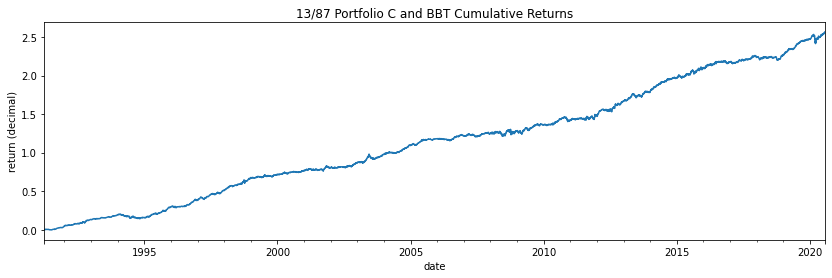

In [22]:
ws, pf_c_overlay_sharpe = maximize_sharpe_ratio([pf_c_rets, pf_bbt_rets], risk_free_rate)
pf_c_overlay_rets = ws[0] * pf_c_rets + ws[1] * pf_bbt_rets
pf_c_overlay_total_ret = compute_total_return(pf_c_overlay_rets)
pf_c_overlay_ann_ret = compute_annualized_return(pf_c_overlay_rets)
pf_c_overlay_cum_rets = compute_cumulative_return_history(pf_c_overlay_rets)
pf_c_overlay_vol = compute_annualized_volatility(pf_c_overlay_rets)

display_portfolio(pf_c_overlay_total_ret, pf_c_overlay_ann_ret, pf_c_overlay_cum_rets,
                  pf_c_overlay_sharpe, pf_c_overlay_vol,
                  title=f'{round(ws[0] * 100)}/{round(ws[1] * 100)} Portfolio C and BBT')

```
======  Portfolio C: 60/40 Global Equities and Bonds  ======
Total Return: 485.91%
Annualized Return: 6.22%
Sharpe Ratio: 0.45114
Volatility: 0.08775
```

![](pf_c_cumulative.jpg)

One could probably guess how this might interact with a 60/40 portfolio. We achieve nearly double the Sharpe ratio and a quarter of the volatility here by mostly investing in the BBT signal.

```
======  13/87 Portfolio C and BBT  ======
Total Return: 255.35%
Annualized Return: 4.42%
Sharpe Ratio: 0.83543
Volatility: 0.02264
```

![](pf_c_overlay_cumulative.jpg)

## All Together Now

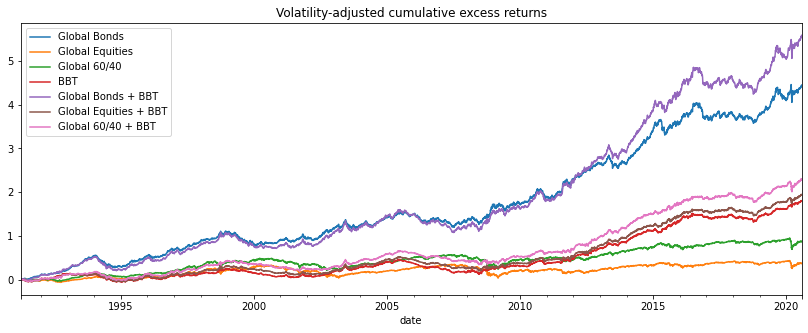

In [23]:
plt.figure(figsize=(14, 5))
target_vol = 0.05

labels = ['Global Bonds', 'Global Equities', 'Global 60/40', 'BBT', 
          'Global Bonds + BBT', 'Global Equities + BBT', 'Global 60/40 + BBT']

for name, lbl in zip(['a', 'b', 'c', 'bbt', 'a_overlay', 'b_overlay', 'c_overlay'], labels):
    curr_rets, curr_vol = vars()[f'pf_{name}_rets'], vars()[f'pf_{name}_vol']
    compute_cumulative_return_history(
        (curr_rets - risk_free_rate_daily) * (target_vol / curr_vol)
    ).plot(label=lbl)
    
plt.legend()
plt.title('Volatility-adjusted cumulative excess returns')
plt.show()

NameError: name 'pf_bbt_cumulative_rets' is not defined

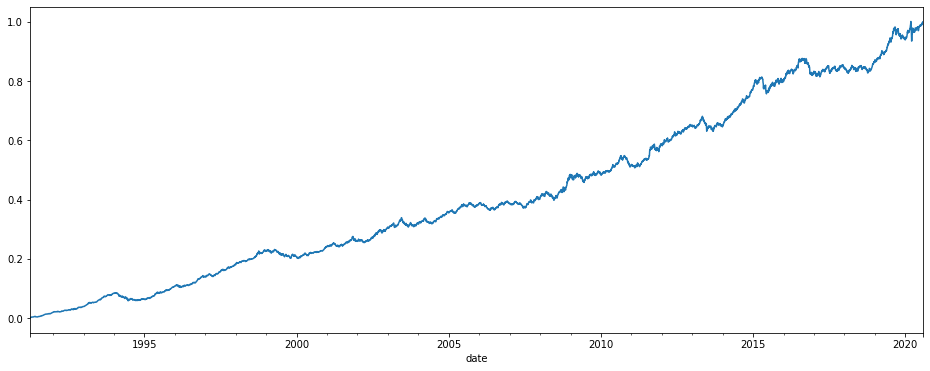

In [24]:
plt.figure(figsize=(16, 6))
(pf_a_cum_rets / pf_a_total_ret).plot(label='Global Bonds')
(pf_bbt_cumulative_rets / pf_bbt_total_ret).plot(label='BBT')
(pf_a_overlay_cum_rets / pf_a_overlay_total_ret).plot(label='Global Bonds + BBT')
(pf_b_overlay_cum_rets / pf_b_overlay_total_ret).plot(label='Global Equities + BBT')
(pf_c_overlay_cum_rets / pf_c_overlay_total_ret).plot(label='Global 60/40 + BBT')
plt.legend()
plt.title('Cumulative returns adjusted for 100% total return')
plt.show()

Lastly, we'll look at the cumulative return history adjusted so that each portfolio has 100% total return at the end, in order to better visualize the volatility over the duration.

![](return_adjusted_cumulative.jpg)

# Questions?